In [34]:
import pandas as pd

# 读取数据
test_file_path = './data/test.csv'
train_file_path = './data/train.csv'

test_df = pd.read_csv(test_file_path)
train_df = pd.read_csv(train_file_path)

# 查看每列数据类型
for column in train_df.columns:
    print(column, train_df[column].dtype)

# 检查数据中是否有缺失值
test_missing_values = test_df.isnull().sum()
train_missing_values = train_df.isnull().sum()

# 输出缺失值信息
print(f"Test DataFrame 缺失值情况:\n{test_missing_values}")
print(f"\nTrain DataFrame 缺失值情况:\n{train_missing_values}")

id int64
Gender object
Age float64
Height float64
Weight float64
family_history_with_overweight object
FAVC object
FCVC float64
NCP float64
CAEC object
SMOKE object
CH2O float64
SCC object
FAF float64
TUE float64
CALC object
MTRANS object
NObeyesdad object
Test DataFrame 缺失值情况:
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64

Train DataFrame 缺失值情况:
id                                0
Gender                            0


In [35]:
# 数据预处理(无缺失值)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

# 定义将离散值进行独热编码的函数
def preprocess_data(df):
    # object类型数据为离散数据，将其进行独热编码
    encoder = OneHotEncoder(sparse_output=False)

    # 选择需要进行独热编码的列
    columns_to_encode = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

    # 使用 OneHotEncoder 对数据进行编码
    encoded_data = encoder.fit_transform(df[columns_to_encode])

    # 将编码后的数据转化为 DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

    # 连接原始数据框和编码后的数据
    df_encoded = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)
    return df_encoded

# 将训练集和测试集中离散值分别进行独热编码
train_df_encoded = preprocess_data(train_df)
test_df_encoded = preprocess_data(test_df)

# 将预测目标进行标签编码
label_encoder = LabelEncoder()
train_df_encoded['NObeyesdad'] = label_encoder.fit_transform(train_df_encoded['NObeyesdad'])

# 将训练集和测试集中连续值进行归一化
scaler = MinMaxScaler()
train_df_encoded[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'FAF', 'TUE']] = scaler.fit_transform(train_df_encoded[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'FAF', 'TUE']])
test_df_encoded[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'FAF', 'TUE']] = scaler.transform(test_df_encoded[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'FAF', 'TUE']])

# 插入缺失列到特定位置以确保训练集测试集列顺序一致
train_calc_frequently_index = train_df_encoded.columns.get_loc('CALC_Frequently') 
train_df_encoded.insert(train_calc_frequently_index, 'CALC_Always', 0)

# 去除训练集、测试集中id列
train_df_encoded = train_df_encoded.drop(columns=['id'])
test_df_encoded = test_df_encoded.drop(columns=['id'])

print(train_df_encoded.head(5))
print(test_df_encoded.head(5))

        Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0  0.222192  0.475586  0.338497  0.500000  0.661099  2.763573  0.000000   
1  0.085106  0.209260  0.142792  0.500000  0.666667  2.000000  0.333333   
2  0.085106  0.497391  0.088577  0.440267  0.137228  1.910378  0.288682   
3  0.147931  0.496002  0.732007  1.000000  0.666667  1.674061  0.489288   
4  0.375342  0.883049  0.434708  0.839832  0.323824  1.979848  0.655991   

        TUE  NObeyesdad  Gender_Female  ...  SCC_yes  CALC_Always  \
0  0.488237           6            0.0  ...      0.0            0   
1  0.500000           1            1.0  ...      0.0            0   
2  0.836792           0            1.0  ...      0.0            0   
3  0.390099           4            1.0  ...      0.0            0   
4  0.465861           6            0.0  ...      0.0            0   

   CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  \
0              0.0             1.0      0.0            

In [ ]:
# 使用XGBoost对训练集进行预测
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 1. 划分特征 (X) 和目标变量 (y)
X = train_df_encoded.drop(columns=['NObeyesdad'])
y = train_df_encoded['NObeyesdad']

# 2. 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 初始化 XGBoost 分类器,定义多分类、类别数、评估指标、随机种子等参数
model = XGBClassifier(
    objective='multi:softmax',           # 多分类
    num_class=len(y.unique()),           # 类别数
    eval_metric='mlogloss',              # 评估指标
    use_label_encoder=False,             # 避免警告
    random_state=42
)

# 4. 训练模型
model.fit(X_train, y_train)

# 5. 对验证集进行预测
y_val_pred = model.predict(X_val)

# 6. 评估模型：计算验证集的准确率
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# 7. 使用训练好的模型对测试集进行预测
X_test = test_df_encoded
y_test_pred = model.predict(X_test)

# 将预测值映射回原始数据
y_test_pred_original = label_encoder.inverse_transform(y_test_pred)

# 将这些预测结果添加到测试集的 DataFrame 中
prediction_df = pd.DataFrame()
prediction_df['id'] = test_df['id']
prediction_df['Predicted_NObeyesdad'] = y_test_pred_original

# 查看映射后的结果
print(prediction_df.head())


d:\code\Python\artificial intelligence course\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 90.20%
      id Predicted_NObeyesdad
0  20758      Obesity_Type_II
1  20759   Overweight_Level_I
2  20760     Obesity_Type_III
3  20761       Obesity_Type_I
4  20762     Obesity_Type_III


使用XGBoost模型进行预测结果

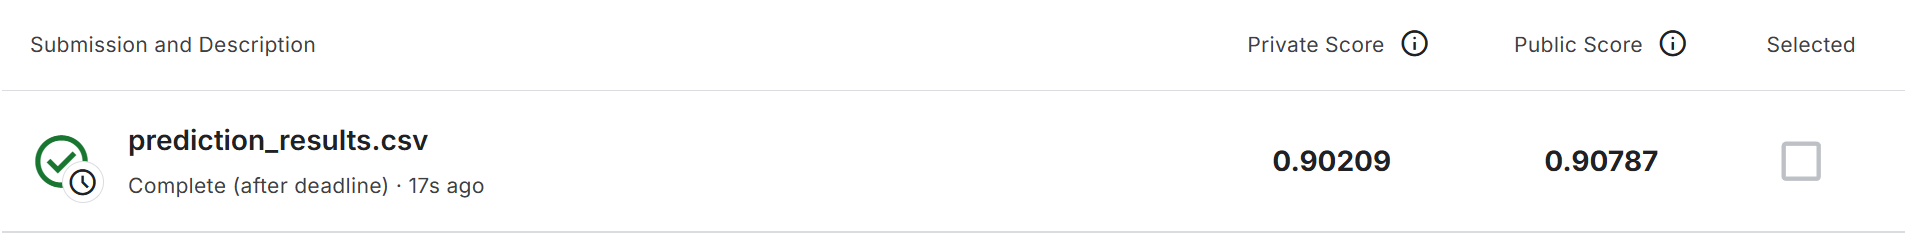

In [ ]:
# 将预测结果写回文件中
prediction_df.to_csv('prediction_results.csv', index=False)

# 输出文件保存成功的提示
print("预测结果已成功保存到 prediction_results.csv")


预测结果已成功保存到 prediction_results.csv
